In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from keras import ops

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

1. Data preparation

In [ ]:
epochs = 10
batch_size = 16
margin = 1
# Load MNIST data
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Create a mask to filter only digits 3 and 7
train_mask = np.isin(y_train, [3, 7])
test_mask = np.isin(y_test, [3, 7])

# Filter the data using the mask
x_train_filtered = x_train[train_mask]
y_train_filtered = y_train[train_mask]
x_test_filtered = x_test[test_mask]
y_test_filtered = y_test[test_mask]

# Convert labels: 3 -> 0, 7 -> 1
y_train_filtered = np.where(y_train_filtered == 3, 0, 1)
y_test_filtered = np.where(y_test_filtered == 3, 0, 1)



In [ ]:
import pandas as pd
df=pd.DataFrame(y_train_filtered)
df.value_counts()

,count
0,
1,6265
0,6131


In [ ]:
# Normalize the data
x_train_filtered= x_train_filtered.astype("float32")
x_test_filtered = x_test_filtered.astype("float32")

# Expand dimensions for channels
x_train_filtered = np.expand_dims(x_train_filtered, axis=-1)
x_test_filtered = np.expand_dims(x_test_filtered, axis=-1)



22.12- Binary classification if you are the 3 or you are not 3 (by SNN)

In [ ]:
# Adjusted function to create binary pairs
def create_binary_pairs(x,y):
    """Create pairs for binary classification with a target digit.
    pair_images = []
    pair_labels = []

    target_indices = np.where(labels == target_digit)[0]
    non_target_indices = np.where(labels != target_digit)[0]

    # Create positive pairs (target digit with itself)
    for i in range(len(target_indices) - 1):
        pair_images.append([images[target_indices[i]], images[target_indices[i + 1]]])
        pair_labels.append(1)  # Positive pair (both are target digit)

        # Create a negative pair (target digit with a non-target digit)
        neg_index = np.random.choice(non_target_indices)
        pair_images.append([images[target_indices[i]], images[neg_index]])
        pair_labels.append(0)  # Negative pair (target vs non-target)

    return np.array(pair_images), np.array(pair_labels)
    """
    num_classes =2
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # Add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # Add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


In [ ]:
# Split the training data into training and validation sets
from sklearn.model_selection import train_test_split

x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_filtered, y_train_filtered, test_size=0.2, random_state=42
)


In [ ]:
# Create binary pairs for training, validation, and testing
train_pairs, train_labels = create_binary_pairs(x_train_filtered, y_train_filtered)
val_pairs, val_labels = create_binary_pairs(x_val, y_val)
test_pairs, test_labels = create_binary_pairs(x_test_filtered, y_test_filtered)

# Split the pairs into their two components
x_train_1, x_train_2 = train_pairs[:, 0], train_pairs[:, 1]

# Split the validation pairs into their two components
x_val_1, x_val_2 = val_pairs[:, 0], val_pairs[:, 1]

x_test_1 = test_pairs[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = test_pairs[:, 1]


In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

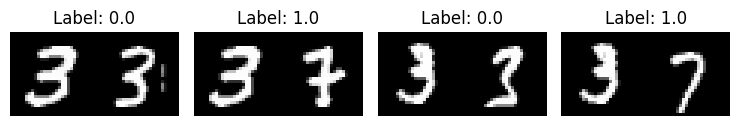

In [ ]:
visualize(train_pairs[:-1], train_labels[:-1], to_show=4, num_col=4)

In [ ]:
#Print the shapes to confirm
print(f"train_pairs shape: {train_pairs.shape}, train_labels shape: {train_labels.shape}")
print(f"val_pairs shape: {val_pairs.shape}, val_labels shape: {val_labels.shape}")
print(f"test_pairs shape: {test_pairs.shape}, test_labels shape: {test_labels.shape}")

train_pairs shape: (24792, 2, 28, 28, 1), train_labels shape: (24792,)
val_pairs shape: (4960, 2, 28, 28, 1), val_labels shape: (4960,)
test_pairs shape: (4076, 2, 28, 28, 1), test_labels shape: (4076,)


In [ ]:
# Adjust the euclidean distance function and ensure proper calculation
def euclidean_distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))


In [ ]:
import numpy as np

# Count the number of positive and negative pairs in the training and testing sets
num_positive_train = np.sum(train_labels == 0)
num_negative_train = np.sum(train_labels == 1)

num_positive_test = np.sum(test_labels == 0)
num_negative_test = np.sum(test_labels == 1)

# Print the results
print(f'Number of positive pairs in the training set: {num_positive_train}')
print(f'Number of negative pairs in the training set: {num_negative_train}')

print(f'Number of positive pairs in the test set: {num_positive_test}')
print(f'Number of negative pairs in the test set: {num_negative_test}')

Number of positive pairs in the training set: 12396
Number of negative pairs in the training set: 12396
Number of positive pairs in the test set: 2038
Number of negative pairs in the test set: 2038


In [ ]:
import keras
from keras import ops

# Define the base network
# Define the model with the new loss function
input = keras.layers.Input((28, 28, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)


388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


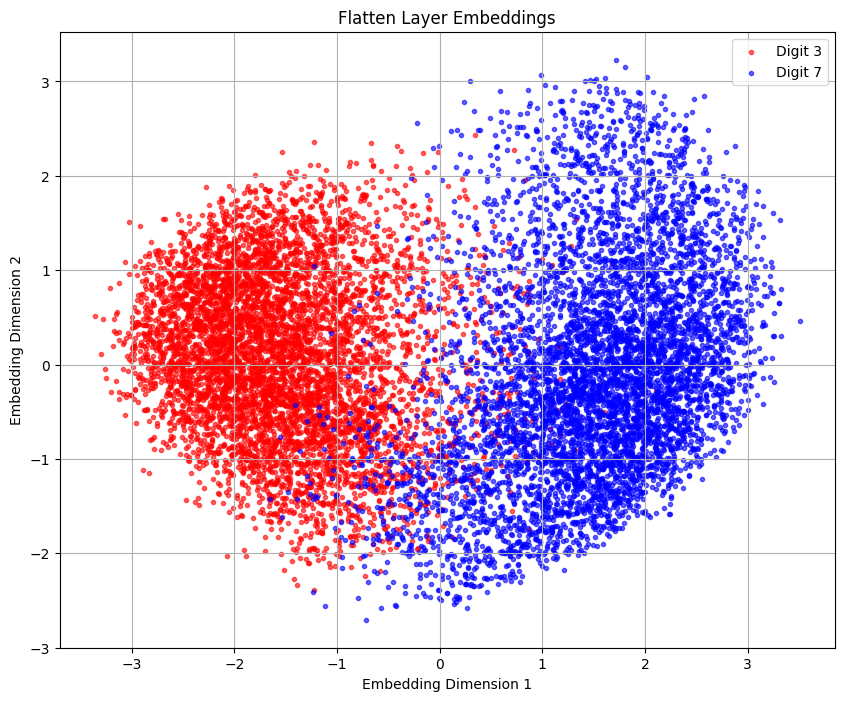

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define a model to output the Flatten layer
embedding_model = keras.Model(inputs=input, outputs=x)

# Extract embeddings from the Flatten layer for training data
train_embeddings = embedding_model.predict(x_train_filtered.reshape(-1, 28, 28, 1))

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
train_embeddings_2d = pca.fit_transform(train_embeddings)

# Plot the embeddings
def plot_flatten_embeddings(embeddings_2d, labels):
    """Plot 2D embeddings from the Flatten layer with labels."""
    plt.figure(figsize=(10, 8))

    for digit, color, label_name in zip([0, 1], ["red", "blue"], ["Digit 3", "Digit 7"]):
        idx = labels == digit
        plt.scatter(
            embeddings_2d[idx, 0],
            embeddings_2d[idx, 1],
            label=label_name,
            alpha=0.6,
            s=9,
            c=color,
        )

    plt.title("Flatten Layer Embeddings")
    plt.xlabel("Embedding Dimension 1")
    plt.ylabel("Embedding Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot embeddings for the training data
plot_flatten_embeddings(train_embeddings_2d, y_train_filtered)

In [ ]:
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(2, activation="tanh")(x)
embedding_network = keras.Model(input, x)

input_1 = keras.layers.Input((28, 28, 1))
input_2 = keras.layers.Input((28, 28, 1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
# Custom contrastive loss remains unchanged
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - y_pred, 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [ ]:
# Compile the model
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

# DistanceLogger callback to track changes in positive and negative distances
class DistanceLogger(tf.keras.callbacks.Callback):
    def __init__(self, pairs, labels):
        super().__init__()
        self.pairs = pairs
        self.labels = labels

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.pairs)
        positive_distances = predictions[self.labels == 0]  # Positive pairs
        negative_distances = predictions[self.labels == 1]  # Negative pairs
        mean_positive_distance = positive_distances.mean()
        mean_negative_distance = negative_distances.mean()

        print(
            f"Epoch {epoch + 1}: "
            f"Mean Positive Distance = {mean_positive_distance:.4f}, "
            f"Mean Negative Distance = {mean_negative_distance:.4f}"
        )

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_5 (Functional) │ (None, 2)              │          3,262 │ input_layer_4[0][0],   │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_5[0][0],    │
│                           │                        │                │ functional_5[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 1)              │              4 │ lambda_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │              2 │ batch_normalization_5… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,268 (12.77 KB)

 Trainable params: 2,752 (10.75 KB)

 Non-trainable params: 516 (2.02 KB)

Epoch 1/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
Epoch 1: Mean Positive Distance = 0.4985, Mean Negative Distance = 0.4987
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


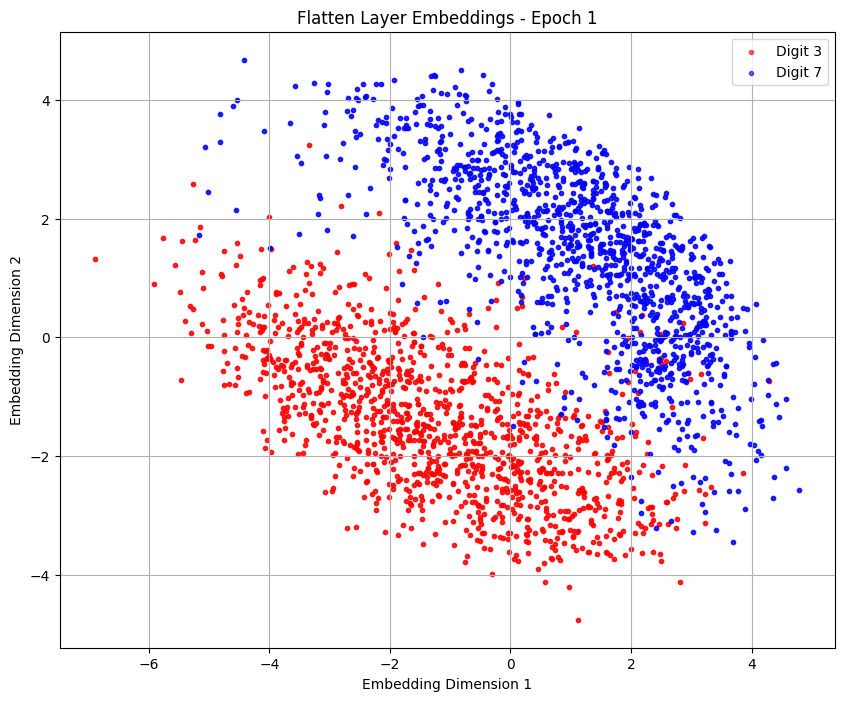

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 60s 35ms/step - accuracy: 0.4979 - loss: 0.2541 - val_accuracy: 0.4905 - val_loss: 0.2502
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
Epoch 2: Mean Positive Distance = 0.4998, Mean Negative Distance = 0.4998
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


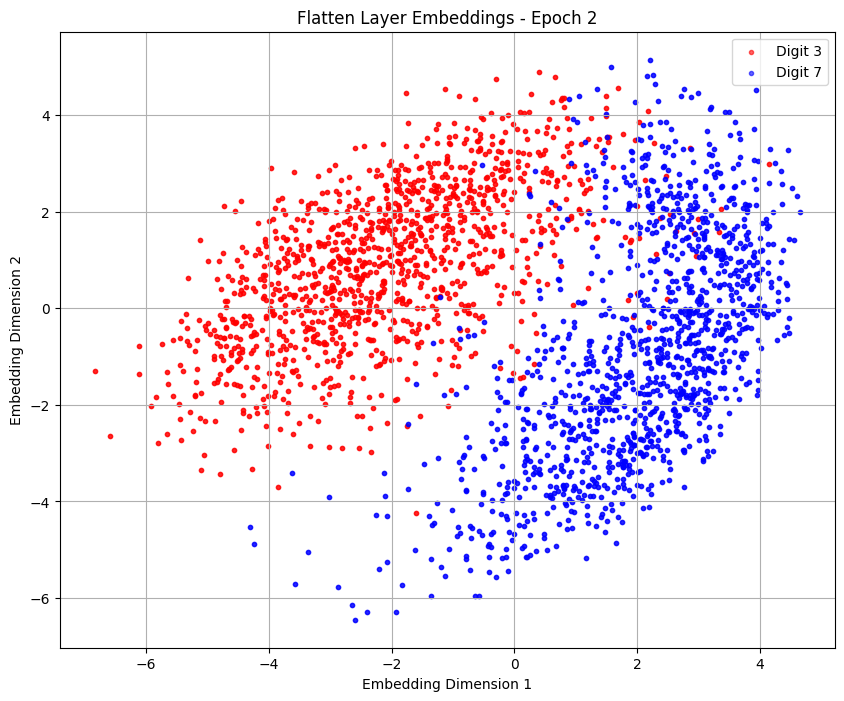

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.4971 - loss: 0.2500 - val_accuracy: 0.4974 - val_loss: 0.2500
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
Epoch 3: Mean Positive Distance = 0.4148, Mean Negative Distance = 0.5798
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


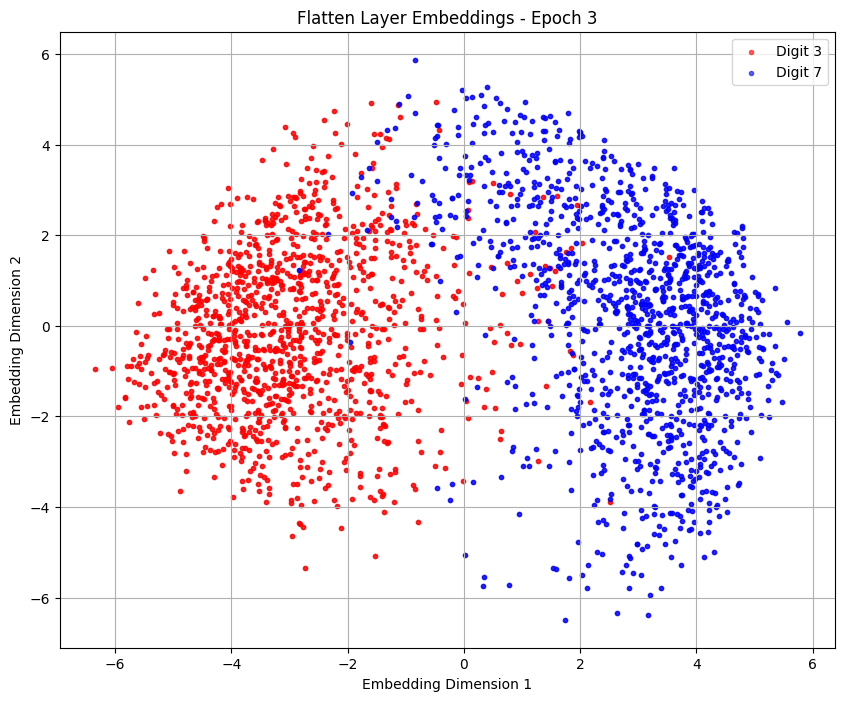

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.5057 - loss: 0.2496 - val_accuracy: 0.9639 - val_loss: 0.1752
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
Epoch 4: Mean Positive Distance = 0.0292, Mean Negative Distance = 0.9730
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


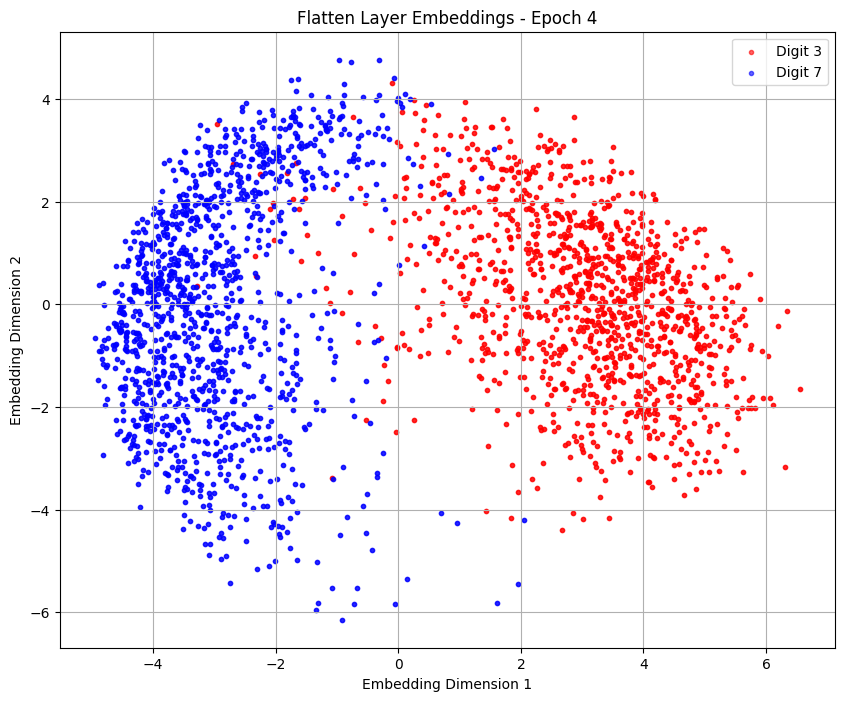

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.9568 - loss: 0.1107 - val_accuracy: 0.9881 - val_loss: 0.0099
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Epoch 5: Mean Positive Distance = 0.0094, Mean Negative Distance = 0.9897
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


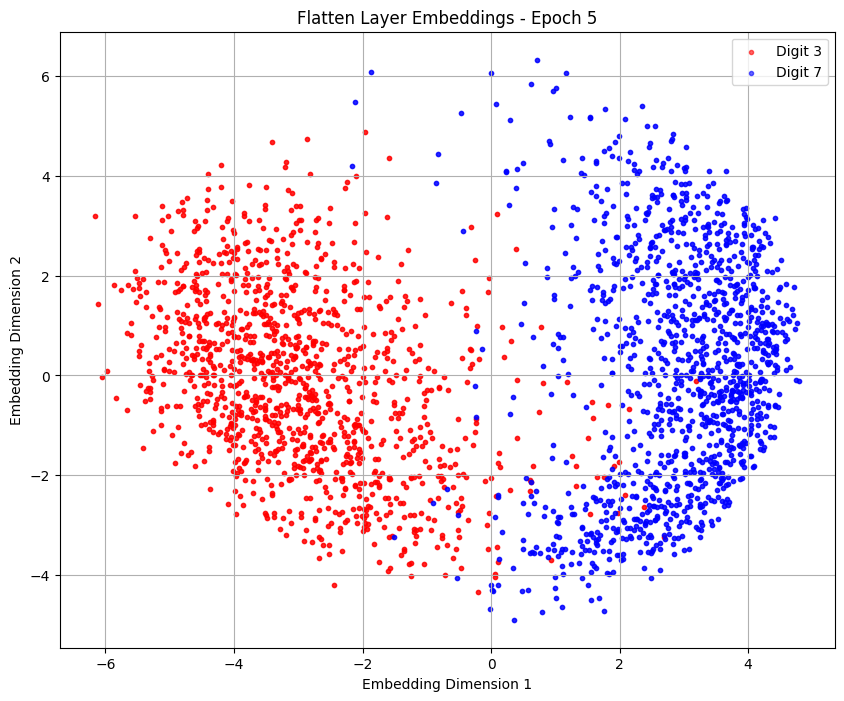

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 86s 32ms/step - accuracy: 0.9804 - loss: 0.0170 - val_accuracy: 0.9925 - val_loss: 0.0056
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
Epoch 6: Mean Positive Distance = 0.0084, Mean Negative Distance = 0.9900
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


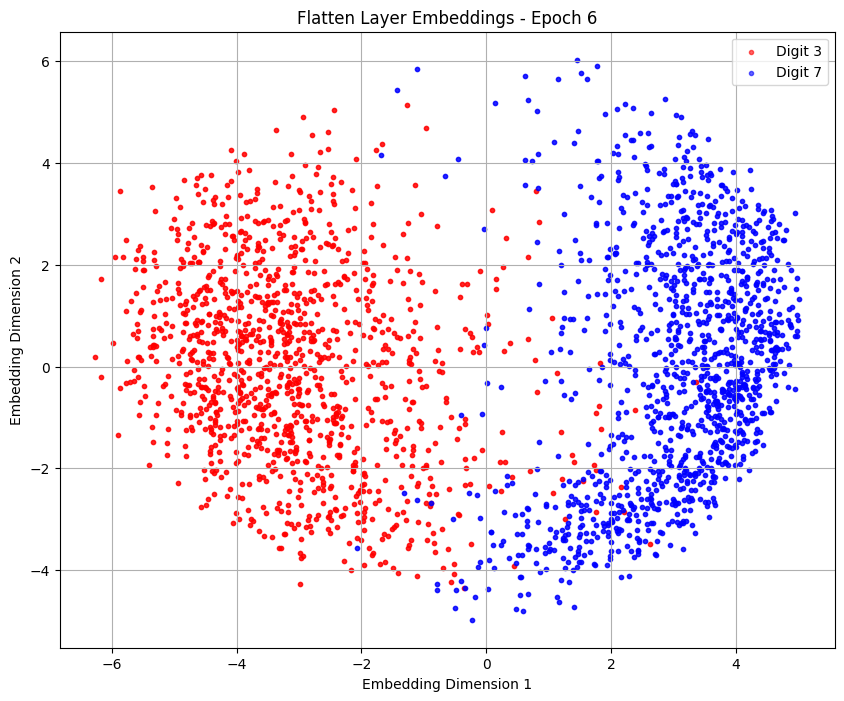

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.9836 - loss: 0.0138 - val_accuracy: 0.9919 - val_loss: 0.0072
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
Epoch 7: Mean Positive Distance = 0.0063, Mean Negative Distance = 0.9951
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


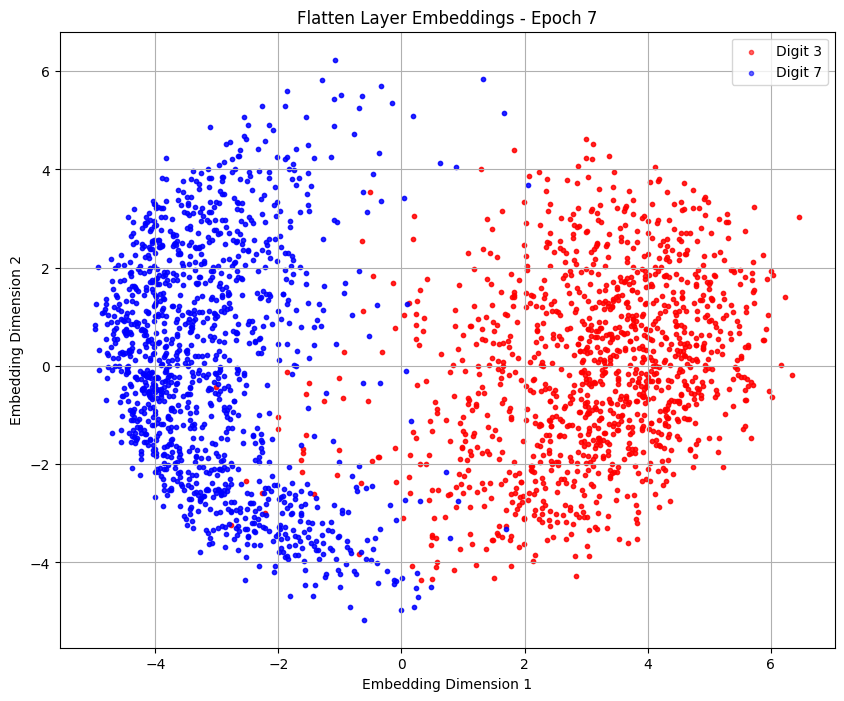

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.9867 - loss: 0.0115 - val_accuracy: 0.9958 - val_loss: 0.0031
Epoch 8/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
Epoch 8: Mean Positive Distance = 0.0042, Mean Negative Distance = 0.9957
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


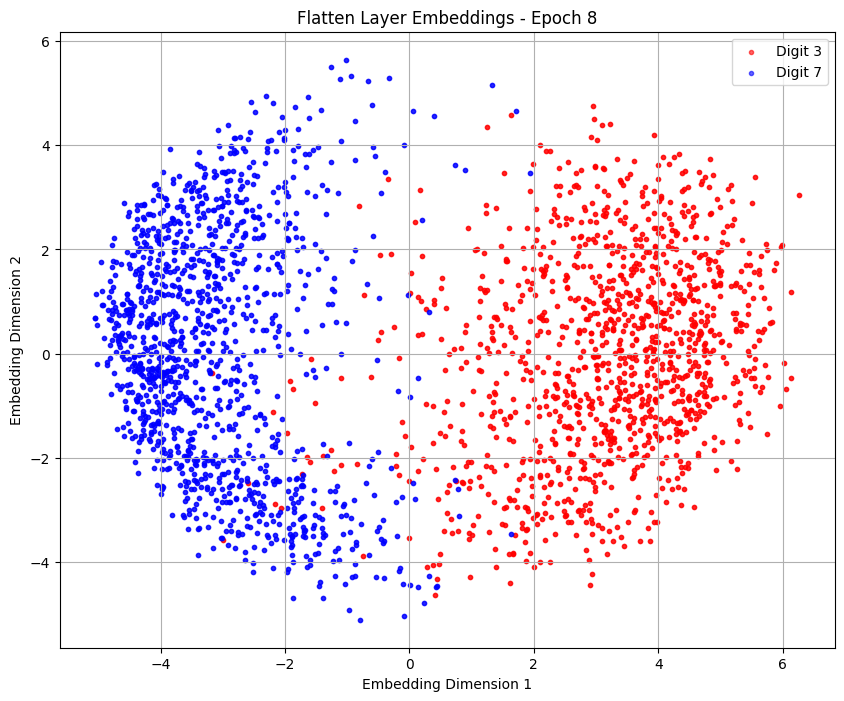

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.9881 - loss: 0.0105 - val_accuracy: 0.9986 - val_loss: 0.0014
Epoch 9/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
Epoch 9: Mean Positive Distance = 0.0052, Mean Negative Distance = 0.9967
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


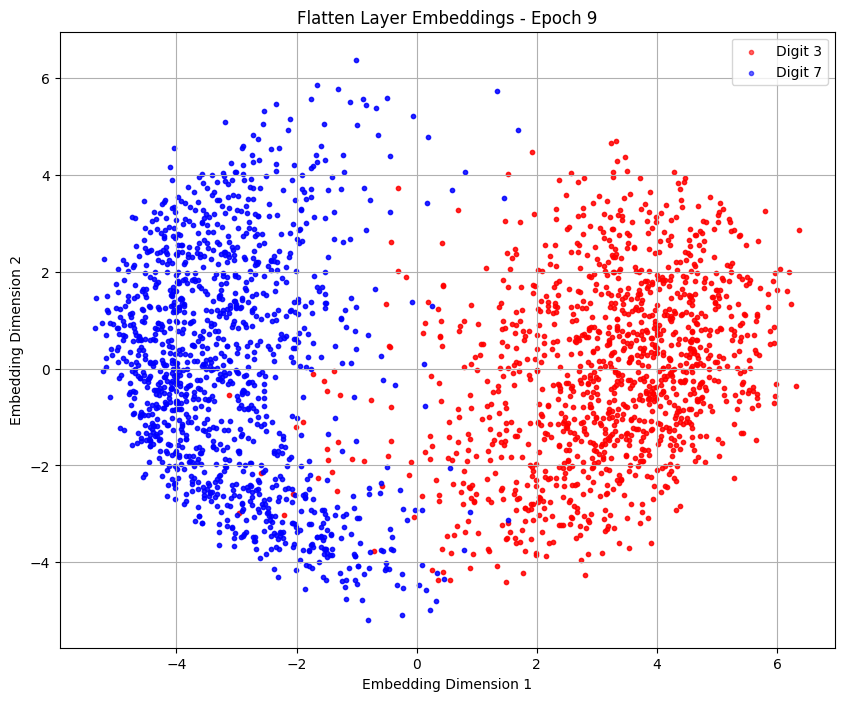

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9903 - loss: 0.0083 - val_accuracy: 0.9966 - val_loss: 0.0028
Epoch 10/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Epoch 10: Mean Positive Distance = 0.0036, Mean Negative Distance = 0.9958
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


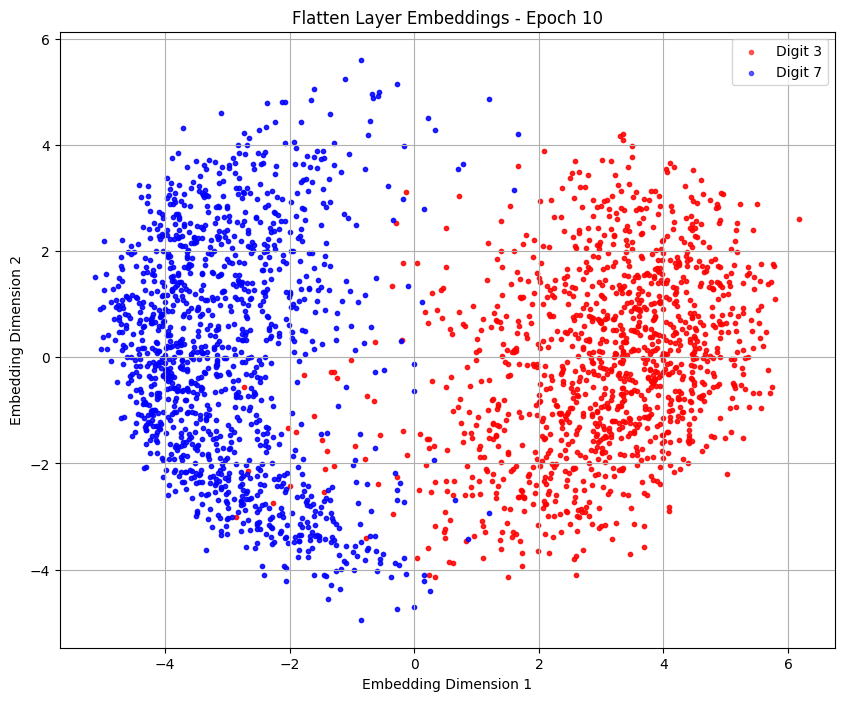

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9904 - loss: 0.0078 - val_accuracy: 0.9978 - val_loss: 0.0017


In [ ]:
class EmbeddingPlotter(keras.callbacks.Callback):
    def __init__(self, embedding_model, data, labels, epoch_interval=1):
        """
        Callback to plot embeddings after each epoch.

        Args:
            embedding_model: The embedding network.
            data: Input data to generate embeddings (e.g., validation data).
            labels: Corresponding labels for the data.
            epoch_interval: Interval (in epochs) to plot the embeddings.
        """
        super().__init__()
        self.embedding_model = embedding_model
        self.data = data
        # Replicate the labels to match the data size
        self.labels = np.repeat(labels, 2) # changed line
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        # Only plot at the specified interval
        if (epoch + 1) % self.epoch_interval == 0:
            # Generate embeddings
            embeddings = self.embedding_model.predict(self.data)

            # Reduce dimensionality to 2D using PCA
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings)

            # Plot the embeddings
            plt.figure(figsize=(10, 8))
            for digit, color, label_name in zip([0, 1], ["red", "blue"], ["Digit 3", "Digit 7"]):
                idx = self.labels == digit
                plt.scatter(
                    embeddings_2d[idx, 0],
                    embeddings_2d[idx, 1],
                    label=label_name,
                    alpha=0.6,
                    s=9,
                    c=color,
                )

            plt.title(f"Flatten Layer Embeddings - Epoch {epoch + 1}")
            plt.xlabel("Embedding Dimension 1")
            plt.ylabel("Embedding Dimension 2")
            plt.legend()
            plt.grid(True)
            plt.show()

#flatten_layers = [layer for layer in embedding_network.layers if isinstance(layer, keras.layers.Flatten)]
#flatten_layer = flatten_layers[0]  # Get the first Flatten layer


# Instantiate the embedding model (flatten layer output only)
embedding_plot_model = keras.Model(
    inputs=embedding_network.input,
    outputs=embedding_network.get_layer('flatten_1').output   # Use the correct layer name
)


# Ensure x_val_filtered has the correct shape
if len(x_val_1.shape) == 2:  # Flattened images
    x_val_1 = x_val_1.reshape(-1, 28, 28, 1)

embedding_plotter = EmbeddingPlotter(
    embedding_model=embedding_plot_model,
    data=x_val_1,  # Still use x_val_1 as input data
    labels=y_val,  # Use y_val (the true labels) instead of x_val_2
    epoch_interval=1
)


history = siamese.fit(
    [x_train_1, x_train_2],  # Two components of training pairs
    train_labels,            # Labels for training pairs
    validation_data=([x_val_1, x_val_2], val_labels),  # Validation data
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[DistanceLogger(pairs=[x_train_1, x_train_2], labels=train_labels), embedding_plotter],
)

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], test_labels)
print("test loss, test acc:", results)

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9935 - loss: 0.0054
test loss, test acc: [0.003579199779778719, 0.9958292245864868]


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


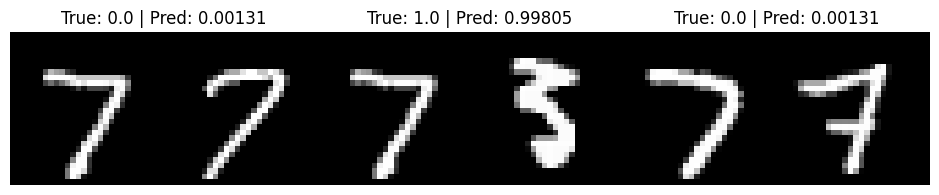

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(test_pairs, test_labels, to_show=3, predictions=predictions, test=True)

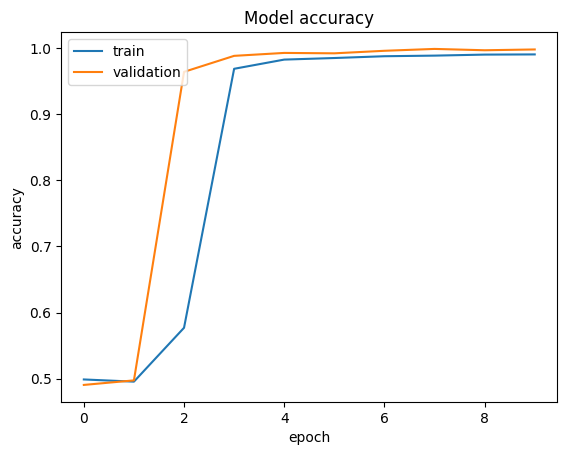

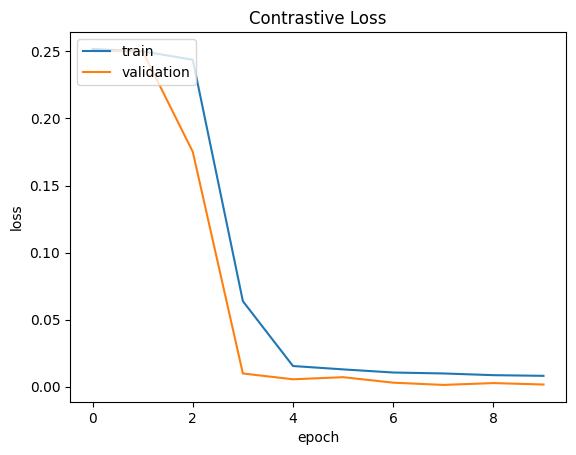

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")